# **FCN - Fully Convolutional Networks (Image Segmentation)**
**Step 1**. Building a Network

**Step 2**. Loading dataset

**Step 3**. Training

**Step 4**. Testing/Prediction

**Step 5**. Results

Our predicted results as follows

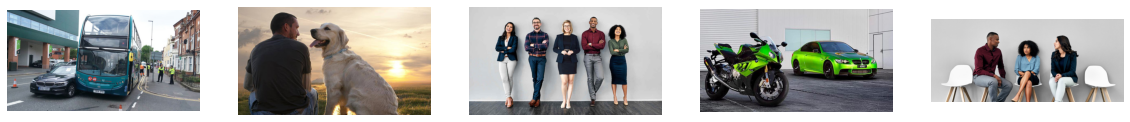

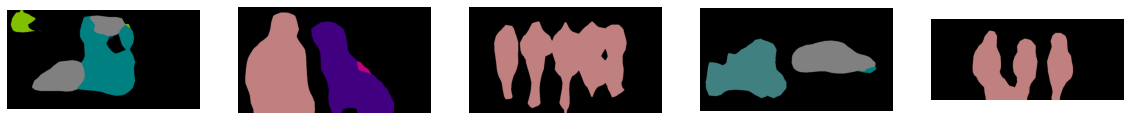

Importing necessary Libraries

In [ ]:
!pip install d2l==0.17.1
import torch
import torchvision
from torchsummary import summary
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import os

# **1. Building a Network**

We have used Resnet18 from torchvision as a backbone for initial layers and customised the last layers according to the FCN paper by adding the 1x1 and transposed convolutional layers.

In [ ]:
resnet_model = torchvision.models.resnet18(pretrained=True)

We will remove the following layers and add our customised layers

In [ ]:
list(resnet_model.children())[-3:]

The fully convolutional network instance fcn_model is then created. Except for the final global average pooling layer and the fully-connected layer closest to the output, it copies all of the pretrained layers in the ResNet-18.


In [ ]:
fcn_model = nn.Sequential(*list(resnet_model.children())[:-2])

Following that, we employ an 1x1 convolutional layer to convert the number of output channels into the number of classes that are 21 including background in the Pascal VOC2012 dataset.

Finally, we must (increase the height and width of the feature maps by 32 times) to restore them to their original height and width.

In [ ]:
out_classes = 21
# 1x1 conv
fcn_model.add_module('final_conv2d', nn.Conv2d(512, out_classes, kernel_size=1))

# transposed conv
fcn_model.add_module('transpose_conv2d', nn.ConvTranspose2d(out_classes, out_classes,
                                    kernel_size=64, padding=16, stride=32))

**Initialiazation of Transposed Convolutional Layer**

The height and width of feature maps is increased by using a transposed convolutional layer. In image processing, we may need to scale an image up, which is known as upsampling. One of the most common upsampling techniques is bilinear interpolation. It is also frequently used to initialize transposed convolutional layers.

In [ ]:
def bilinear(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
        
    og = (torch.arange(kernel_size).reshape(-1, 1), torch.arange(kernel_size).reshape(1, -1))
    
    filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)
    
    weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))
    
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

We have initialize the transposed convolutional layer with upsampling of bilinear interpolation.

In [ ]:
W = bilinear(out_classes, out_classes, 64)
fcn_model.transpose_conv2d.weight.data.copy_(W);

### **Implementation of skip connections. Do not run this code we have already used the residual blocks from Resnet Architechture. We have just added here for explanation how skip connections are working.**

Creating a residual block

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=[1, 1], downsample=None):
       
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride[0], 
            padding=1, bias=False
        )

        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=stride[1], 
            padding=1, bias=False
        )

        self.bn = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        # applying a downsample function before adding it to the output
        if(self.downsample is not None):
            residual = downsample(residual)

        out = F.relu(self.bn(self.conv1(x)))
        
        out = self.bn(self.conv2(out))
        # note that adding residual before activation 
        out = out + residual
        out = F.relu(out)
        return out

In [ ]:
# downsample using 1 * 1 convolution
downsample = nn.Sequential(
    nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
    nn.BatchNorm2d(128)
)
# First five layers of ResNet-34
resnet_blocks = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
    nn.MaxPool2d(kernel_size=2, stride=2),
    ResidualBlock(64, 64),
    ResidualBlock(64, 64),
    ResidualBlock(64, 128, stride=[2, 1], downsample=downsample)
)

# checking the shape
inputs = torch.rand(1, 3, 100, 100) # rgb image
outputs = resnet_blocks(inputs)
print(outputs.shape)    # shape would be (1, 128, 13, 13)

torch.Size([1, 128, 13, 13])


#**2. Loading Dataset**
We have used the PASCAL VOC 2012 dataset to train our network that includes 21 classes. The train/val data has 11,530 images containing 27,450 ROI annotated 

In [ ]:
def load_data_voc(batch_size, crop_size):
    voc_dir = d2l.download_extract('voc2012', os.path.join('VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    
    train_iter = torch.utils.data.DataLoader(d2l.VOCSegDataset(True, crop_size, voc_dir), 
                                             batch_size,shuffle=True, 
                                             drop_last=True, 
                                             num_workers=num_workers)
    
    test_iter = torch.utils.data.DataLoader(d2l.VOCSegDataset(False, crop_size, voc_dir), 
                                            batch_size,drop_last=True, 
                                            num_workers=num_workers)
    return train_iter, test_iter

In [ ]:
batch_size, crop_size = 32, (320, 480)
train_dataloader, test_dataloader = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


read 1078 examples


#**3. Training**

We can now train our newly constructed fully convolutional network.
Because we have predicted the class for each pixel using the output channel of the transposed convolutional layer, the channel dimension is specified in the loss calculation.

Furthermore, accuracy is calculated based on the correctness of the predicted class for all pixels.

In [ ]:
# Loss function
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

In [ ]:
import numpy as np
def softmax(X):
    exps = np.exp(X)
    return exps / np.sum(exps)

def cross_entropy(X,y):
    m = y.shape[0]
    p = softmax(X)
    log_likelihood = -np.log(p[range(m),y])
    loss = np.sum(log_likelihood) / m
    return loss

In [ ]:
fcn_model.to('cuda')

In [ ]:
# def train(net, train_iter, test_iter, loss, num_epochs, updater): 
#     animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9], legend=['train loss', 'train acc', 'test acc'])
   
#     for epoch in range(num_epochs):
#         train_metrics = d2l.train_epoch_ch3(net, train_iter, loss, updater)
#         test_acc = d2l.evaluate_accuracy(net, test_iter)
#         animator.add(epoch + 1, train_metrics + (test_acc,))
   
#     train_loss, train_acc = train_metrics
#     assert train_loss < 0.5, train_loss
#     assert train_acc <= 1 and train_acc > 0.7, train_acc
#     assert test_acc <= 1 and test_acc > 0.7, test_acc

loss 0.250, train acc 0.916, test acc 0.861
37.5 examples/sec on [device(type='cuda', index=0)]


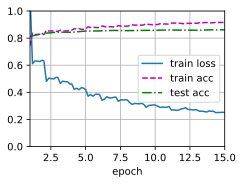

In [ ]:
num_epochs, learning_rate, wd, devices = 15, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(fcn_model.parameters(), lr=learning_rate, weight_decay=wd)

# Training
d2l.train_ch13(fcn_model, train_dataloader, test_dataloader, loss, trainer, num_epochs, devices)

Saving the FCN Model using pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
filename = '/content/drive/MyDrive/DL project/fcn_model.sav'
# pickle.dump(fcn_model, open(filename, 'wb'))

# **4. Testing**

Loading the saved model

In [ ]:
fcn_model = pickle.load(open(filename, 'rb'))

A random Test image of a dog and human

In [ ]:
images = ["/content/test7.jpg", "/content/dog.jpg", "/content/test2.jpg", "/content/test12.jpg", "/content/test11.jpg"]

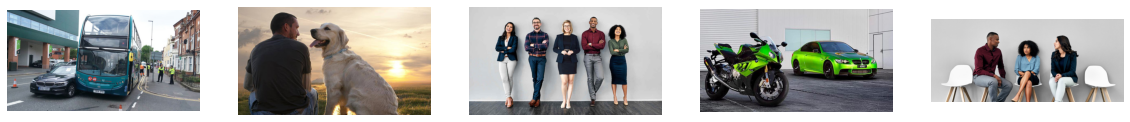

In [ ]:
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    image = mpimg.imread(image)
    plt.imshow(image)
    plt.axis("off")

Apply the transformations needed

In [ ]:
import torchvision.transforms as T
trf = T.Compose([T.Resize(512),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])

print("Input Size")
test_image = {}
for i, image in enumerate(images):
  test_image[i] = trf(Image.open(image)).unsqueeze(0)
  print(test_image[i].shape)

print("\nOutput Size")
pred = {}
for i, image in enumerate(images):
  pred[i] = fcn_model(test_image[i].to(devices[0]))
  print(pred[i].shape)


Input Size
torch.Size([1, 3, 512, 975])
torch.Size([1, 3, 512, 910])
torch.Size([1, 3, 512, 910])
torch.Size([1, 3, 512, 955])
torch.Size([1, 3, 512, 1189])

Output Size
torch.Size([1, 21, 512, 992])
torch.Size([1, 21, 512, 928])
torch.Size([1, 21, 512, 928])
torch.Size([1, 21, 512, 960])
torch.Size([1, 21, 512, 1216])


In [ ]:
import numpy as np
om = {}
for i, image in enumerate(images):
  om[i] = torch.argmax(pred[i].squeeze(), dim=0).detach().cpu().numpy()
  print (np.unique(om[i]))

[ 0  6  7 19 20]
[ 0 12 13 15]
[ 0 15]
[ 0  6  7 14]
[ 0 15]


A helper function to label the classes

In [ ]:
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

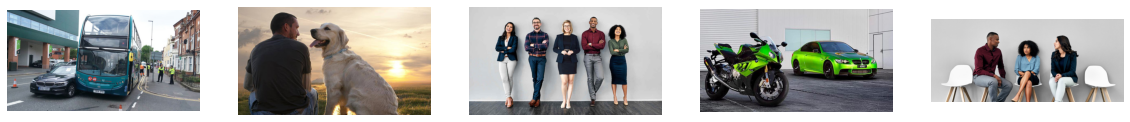

In [ ]:
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    image = mpimg.imread(image)
    plt.imshow(image)
    plt.axis("off")

Predicted Classes with segmentation

In [ ]:
rgb = {}
for i, image in enumerate(images):
  rgb[i] = decode_segmap(om[i])

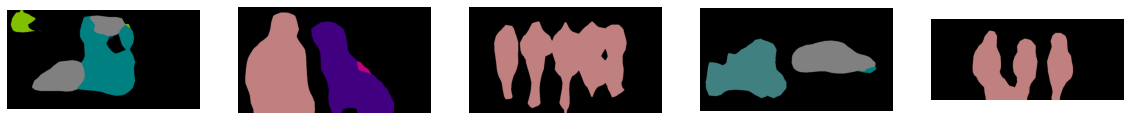

In [ ]:
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(rgb):
    plt.subplot(len(rgb) / columns + 1, columns, i + 1)
    plt.imshow(rgb[i]); 
    plt.axis("off")

--------------------------------------------------------------E  N D--------------------------------------------------------------------